<a href="https://colab.research.google.com/github/ErgoProxy1/Learning_AI/blob/main/makemore_language_model_tuto_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=PaCmpygFfXo&t=18s

In [6]:
words = open('names.txt', 'r').read().splitlines()

In [7]:
print("length",len(words))
print("min", min(len(word) for word in words))
print("max", max(len(word) for word in words))

length 32033
min 2
max 15


We want to create a character level generative language model. The goal is to be able to predict the next character given the previous sequence of characters before it.

For example "isabella" tells us that 'i' is likely to come first, that 's' is likely to come after 'i', that 'a' is likely to come after 'is', etc. (Also that given 'isabella', the word is likely to end)

There are many different types of language models:
- Bigram
- Bag of words
- MLP
- RNN
- GRU
- Transformer (GPT)



# Part 1: Bigram

Very simple model, we always work with two chars at a time (Given x, what's likely after y)

In [8]:
for w in words[:3]:
  for ch1, ch2 in zip(w, w[1:]): # Remember zip favors the shortest string, so for example emma is tuples between emma and mma
    print(ch1, ch2)

e m
m m
m a
o l
l i
i v
v i
i a
a v
v a


In [9]:
# Lets modify this a little to add a start and end indicator
b = {}
for w in words[:3]:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]): # Remember zip favors the shortest string, so for example emma is tuples between emma and mma
    print(ch1, ch2)

<S> e
e m
m m
m a
a <E>
<S> o
o l
l i
i v
v i
i a
a <E>
<S> a
a v
v a
a <E>


In [10]:
# Now let's track our bigrams

bigrams = {} # To keep a count of how often each bigram (pair of chars) occurs
for w in words: # ALL THE WORDS
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]): # Remember zip favors the shortest string, so for example emma is tuples between emma and mma
    b = (ch1, ch2)
    bigrams[b] = bigrams.get(b, 0) + 1
# sorted(bigrams.items(), key = lambda kv: kv[1], reverse = True)

In [11]:
# We have a nice dictionary that tells us about the frequency of pairs, but for machine learning purposes, lets use pytorch tensors
import torch

In [12]:
# Quick examples of tensors
a = torch.zeros((3 , 5))
print(a)
print(a.dtype) #float32 by default
print(a.shape)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
torch.float32
torch.Size([3, 5])


In [13]:
b = torch.zeros((3 , 5), dtype = torch.int32)
print(b)
print(b.dtype)

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=torch.int32)
torch.int32


In [14]:
# If we want to change the value at the first row in the 4th column (0 indexed ofc)
b[1 , 3] = 10
print(b)
b[1, 3] += 1
print(b)

tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0,  0, 10,  0],
        [ 0,  0,  0,  0,  0]], dtype=torch.int32)
tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0,  0, 11,  0],
        [ 0,  0,  0,  0,  0]], dtype=torch.int32)


So let's do it for our dataset. Remember we have a vocabulary size og 26+2 (letters of the alphabet plus our special chars \<S\> and \<E\>). So we'll need a tensor of 28x28 to represent each bigram (row would be the first char, column the second, and the value the frequency)

In [15]:
N = torch.zeros((28, 28), dtype = torch.int32)
lookup_table = {s:i+1 for i, s in enumerate(sorted(list(set(''.join(words)))))} #Put all the words into a string, use set to remove all dups (so its just the alphabet), sort it, then create a dictionary that maps each letter to a number
lookup_table['<S>'] = 26
lookup_table['<E>'] = 26

for w in words:
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
      ix1 = lookup_table[ch1] #index of first char
      ix2 = lookup_table[ch2] #index of second char
      N[ix1, ix2] += 1 # Keep count of occurences

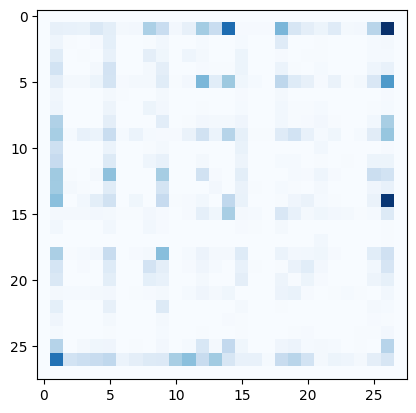

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(N, cmap = 'Blues') # Just to show the tensor in a nicer way, he does it well in the video but Im going to skip it for now
# However we can notice that the last row is completely empty as that represents the <E> char which will never not be at the end. Similar for the <S> and the second-to-last column.

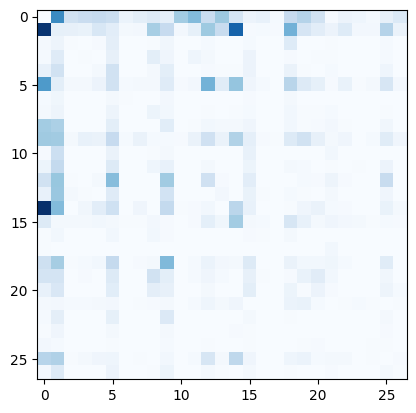

In [17]:
# Let's do it a bit more smartly to avoid empty columns and rows
N = torch.zeros((27, 27), dtype = torch.int32) # One less column and row

lookup_table = {s:i+1 for i, s in enumerate(sorted(list(set(''.join(words)))))} #offset by 1
lookup_table['.'] = 0 # Set just a . as the first row and column. We don't need two characters as we can know logically when a word starts and ends.

reverse_lookup = {i:s for s, i in lookup_table.items()}

for w in words:
  chs = ['.'] + list(w) + ['.'] # Just dots on both sides
  for ch1, ch2 in zip(chs, chs[1:]):
      ix1 = lookup_table[ch1] #index of first char
      ix2 = lookup_table[ch2] #index of second char
      N[ix1, ix2] += 1 # Keep count of occurences

plt.imshow(N, cmap = 'Blues') # Thats a bit better

We now have all the data we need neatly organized into a Tensor. Now we just need to follow these frequencies and start sampling.

In [18]:
N[0, :] #For example, this tells us how often each letter appears at the start (a 4410 times, b 1306 times, etc)

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [19]:
# lets now create our probability vector
probs = N[0].float() # Convert to tensor
probs = probs / probs.sum() # Normalize by dividing each occurence by the total occurences
probs # And the total sum would be 1 since this is just a list of probabilities

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [20]:
g = torch.Generator().manual_seed(2147483647) # Allows us to define a generator for randomness control. We're using the same seed as the video here.
probs_example = torch.rand(3, generator = g)
probs_example = probs_example / probs_example.sum()
probs_example # Confirming we're getting the same data every time

tensor([0.6064, 0.3033, 0.0903])

In [21]:
# https://pytorch.org/docs/stable/generated/torch.multinomial.html
torch.multinomial(probs_example, num_samples = 30, replacement = True, generator = g) # We're going to sample based off the normalized probabilities vector. Replacement says we can pull the same sample more than once
# In theory, 2 should appear less frequently than 1 and 1 less than 0, since 0 has a 60% chance, 30% for 1, and 10% for 2.

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0])

We can apply multinomial sampling in chain to create words!

In [22]:
# Here's a single iteration
g = torch.Generator().manual_seed(2147483647)
i1 = torch.multinomial(probs, num_samples = 1, replacement = True, generator = g).item() # First index sample
print(reverse_lookup[i1]) # Gives us the letter

probs2 = N[i1].float() # Get the matching row of i1
probs2 = probs2 / probs2.sum() # Normalize

i2 = torch.multinomial(probs2, num_samples = 1, replacement = True, generator = g).item() # Second index sample
print(reverse_lookup[i2]) # So this tells us what letter comes after the first one

j
u


In [23]:
# So let's just do it
g = torch.Generator().manual_seed(2147483647)

Probabilities = (N+1).float() #Add 1 for model smoothing, we dont want 0 divisions
# Always make sure to check broadcasting semantics https://pytorch.org/docs/stable/notes/broadcasting.html
# Since ours is 27x27 and 27x1, we're all good
Probabilities /= Probabilities.sum(1, keepdim=True) # Specify we want the sum with respect to the second dimension (columns) and to keep the dimensions (27x1 tensor, not 27 item list)

for i in range(10):
  out = []
  ix = 0
  while True:
    p = Probabilities[ix]
    ix = torch.multinomial(p, num_samples = 1, replacement = True, generator = g).item()
    out.append(ix)
    if ix == 0:
      break
  print(''.join(reverse_lookup[i] for i in out)) #Its terrible, but that's normal. It doesn't have any context beyond the current letter. Explains why sometimes it just generates a single letter, because it doesn't know that single letter was at the start.

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


While what it generates isn't great, it's much better than what a completely uniform distribution would give
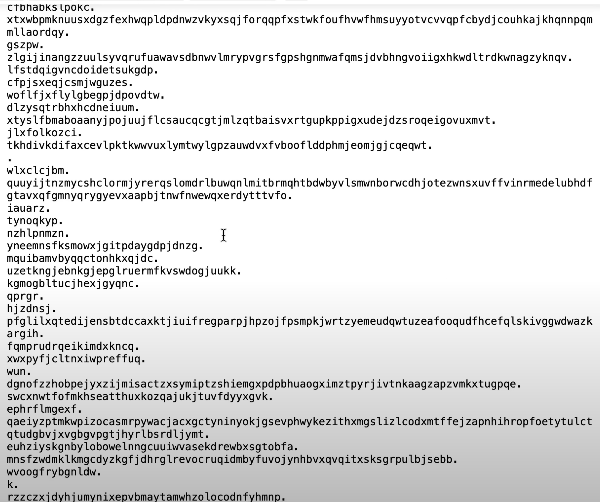

Also remember to respect the broadcasting semantics when manipulating tensors https://pytorch.org/docs/stable/notes/broadcasting.html

For example if we had not put keepdim in our Probabilities sum calculation, we would have had a tensor of shape [27] rather than [27,1] (a column vector). What  this would have a done internally is rather than compare:

> 27 x 27

> 27 x 1

Which is valid, we would have had (because shift to the right):

> 27 x 27

> _ x 27

Which would evaluate to

> 27 x 27

> 1 x 27

Which is not the same at all and would have resulted in a bug. Instead of multiplying a tensor by a column vector, we would have had a row vector! Our column probabilities would have sum to 1, but we want our rows to sum to 1 (Since the rows represent our actual combinations for a given first letter (ja, jb, jc, etc)).

Okay now let's calculate our loss to evaluate the quality of our model. We're going to use the negative log likelihood from maximum likelihood estimation (maximum de vraisemblance).

In [24]:
for w in words[:3]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = lookup_table[ch1]
    ix2 = lookup_table[ch2]
    prob = Probabilities[ix1, ix2]
    print(f'{ch1}{ch2}: {prob:.4f}')
# We can check the probabilities of each pairing. We can tell our Bigram model learned SOMETHING, since some probabilities are much different from 1/27=0.04

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3885
a.: 0.1958
.o: 0.0123
ol: 0.0779
li: 0.1774
iv: 0.0152
vi: 0.3508
ia: 0.1380
a.: 0.1958
.a: 0.1376
av: 0.0246
va: 0.2473
a.: 0.1958


In [25]:
# Now lets add in the log prob. The closer to 0 the better, since that means we're close to a high probability (1). But the numbers tend to dip down quckly as the probability goes down.
# Using log works well because log(a*b*c) = log(a) + log(b) + log(c), which make probability products easier to work with.
log_likelihood = 0.0
n = 0
for w in words[:3]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = lookup_table[ch1]
    ix2 = lookup_table[ch2]
    prob = Probabilities[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
print("likelihood", log_likelihood)
negative_log_likelihood = -log_likelihood
print("negative log likelihood", negative_log_likelihood)
print("average negative log likelihood (probably what we would use as the loss function)", negative_log_likelihood/n)

.e: 0.0478 -3.0410
em: 0.0377 -3.2793
mm: 0.0253 -3.6753
ma: 0.3885 -0.9454
a.: 0.1958 -1.6305
.o: 0.0123 -4.3965
ol: 0.0779 -2.5526
li: 0.1774 -1.7293
iv: 0.0152 -4.1845
vi: 0.3508 -1.0476
ia: 0.1380 -1.9807
a.: 0.1958 -1.6305
.a: 0.1376 -1.9835
av: 0.0246 -3.7041
va: 0.2473 -1.3971
a.: 0.1958 -1.6305
likelihood tensor(-38.8086)
negative log likelihood tensor(38.8086)
average negative log likelihood (probably what we would use as the loss function) tensor(2.4255)


So our model needs to minimize the average negative log likelihood loss.

Our goal is to maximize the likelihood of the data with respect to our parameters, aka maximimize log likelihood, aka minimize negative log likelihood, aka minimize average negative log likelihood

# Part 2 Neural Net

While the bigram is respectable enough, there's no real way to improve it without expanding our dataset. Instead, we will do what we described when we defined our loss function, which is to minimize our loss. A good way to do this is to use good old fashioned neural networks.

We're going to create a neural network that takes in our chars as input, does some stuff in the hidden layers, and outputs a probability distribution. Then using our loss function, we're going to adjust the parameters of our neural net, so that our loss is low (In other words, maximize our probabilities).

In [26]:
# First, lets create the training set of the bigrams (x,y)
xs, ys = [], [] #xs are our inputs, ys are what we are trying to predict, aka the next char in the bigram

lookup_table = {s:i+1 for i, s in enumerate(sorted(list(set(''.join(words)))))} #offset by 1
lookup_table['.'] = 0

reverse_lookup = {i:s for s, i in lookup_table.items()}

for w in words[:1]: #Just the first as an example
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
      ix1 = lookup_table[ch1]
      ix2 = lookup_table[ch2]
      xs.append(ix1)
      ys.append(ix2)

xs = torch.tensor(xs) #Recommend to use .tensor as it can infer the dtype
ys = torch.tensor(ys)

In [27]:
print(xs)
print(ys)
# We can see how it translate (when 0, then 5, aka when ., then e) (This is for .emma.)

tensor([ 0,  5, 13, 13,  1])
tensor([ 5, 13, 13,  1,  0])


We have to think carefully about how we're actually going to feed our inputs and map it all out. We can't just feed integers as we have weight multiplication, a bias to add to the sum, an activation function to pass it through, etc. This would take what is essentially char index information and transform it into something else, which wouldnt tell us much.

A common way of getting around this is **one-hot encoding**. This consists of creating a vector of all zeros, except for the position that corresponds to our integer (For example, 5 would be [0,0,0,0,0,1,0,0...] since our 0 corresponds to the start/end char we defined). This is a better way of representing our index integers in a neural net. Basically we're going to have 27 inputs to the first hidden layer.

In [28]:
import torch.nn.functional as F
x_encoded = F.one_hot(xs, num_classes=len(lookup_table)).float() # Note we want it to be a float
x_encoded.shape # For our example .emma., this creates a 5x27 tensor, with each row representing which of our 27 possible characters corresponds to the input.

torch.Size([5, 27])

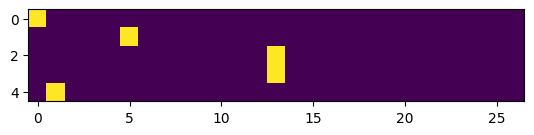

In [29]:
plt.imshow(x_encoded)

Now let's represent our neurons. They will take in our one-hot vectors as inputs and apply weight and bias and acivation on it.

In [30]:
# Now let's represent our neurons
W = torch.randn((27,1)) # Initial weights, generated randomly along a normal distribution
W

tensor([[-1.0703],
        [-1.6285],
        [-0.7956],
        [-0.4456],
        [-0.0061],
        [ 0.4309],
        [ 0.0451],
        [-2.0916],
        [-1.0835],
        [-0.6545],
        [ 0.6338],
        [-1.7437],
        [-1.8313],
        [-0.3368],
        [ 1.9203],
        [ 0.4487],
        [ 0.4082],
        [ 0.8867],
        [-0.0871],
        [ 0.0686],
        [-0.7242],
        [ 0.0315],
        [-1.0070],
        [ 0.8917],
        [ 1.6497],
        [ 0.2401],
        [-0.3444]])

In [31]:
x_encoded @ W #@ is matrix multiplication in PyTorch, which results in a 5x1 tensor since 5x27 @ 27x1
# This would represent the wi*xi (firing rate) values that we would get given five examples

tensor([[-1.0703],
        [ 0.4309],
        [-0.3368],
        [-0.3368],
        [-1.6285]])

This gives a better understanding for a single neuron, but now let's say we want 27 neurons, meaning that we will have 27 inputs to 27 neurons and we don't have any other layers, this is going to be a very small and simple neural net. Our code would change like below. Note that we're leavin our firing rate random, unbiased, and linear (no activation) for now.

In [32]:
W = torch.randn((27,27)) # Replace our 1 with 27, so now we can evaluate in parallel all of the wi*xi values for all 27 of our neurons given our 5 input examples
x_encoded @ W #5x27 @ 27x27 -> 5x27, our wi*xi for each of our 27 neurons

#This is similar to doing (x_encoded[i] * W[:, j]).sum() a bunch of times, its just more efficient to use matrix multiplication

tensor([[ 2.6238, -1.9543, -0.7781,  1.0719,  0.6906, -1.0175,  0.8013, -1.3322,
          0.7087,  0.6578,  0.3050,  2.3164,  0.3330,  1.2944, -0.2089, -0.3664,
          1.4304,  0.2415,  1.7604,  0.4443, -0.7708, -1.3900,  2.7953,  0.5486,
          0.1585, -0.3879, -0.5208],
        [-0.2583, -0.7112,  2.1026, -0.3211,  1.1215, -0.1964, -0.5694, -0.1924,
         -1.4174, -0.0897,  0.8298,  1.0340,  0.4497,  0.1020, -0.1438,  0.7107,
          0.9536, -1.1528,  0.3794,  0.9920, -0.4072,  0.6047, -0.5533,  0.7940,
         -1.0244, -1.1974,  1.4768],
        [ 0.3553, -2.7650, -0.1492,  1.3082, -1.0088, -1.2207, -0.4657,  0.9225,
          0.3631, -1.2199, -0.1085, -1.6065,  1.1489,  1.1502,  0.7103,  3.4263,
         -2.4636, -0.5240,  0.3183, -1.2456,  0.3509, -0.4556, -0.3945,  2.4066,
          1.7484,  1.2963, -1.3619],
        [ 0.3553, -2.7650, -0.1492,  1.3082, -1.0088, -1.2207, -0.4657,  0.9225,
          0.3631, -1.2199, -0.1085, -1.6065,  1.1489,  1.1502,  0.7103,  3.4263

We do have a small problem. A probability distribution is probably not something that a neural network can output. Currently, our randomized outputs are positive and negative real numbers. What WE want is a way to indicate the probabilities of each of our bigrams, so currently this doesnt map well at all.

What we can do is transform these outputs into probabilities using the **softmax** aka by giving us log counts or **logits** (rather than integer counts like we have in our N matrix) that we will then exponeniate (e(x)). So negative numbers will become greater than 0 but less than 1, and positive numbers will become greater than 1.

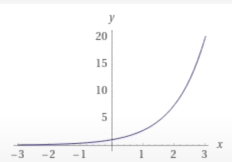

Here is a summary of softmax, where zi is a given logit

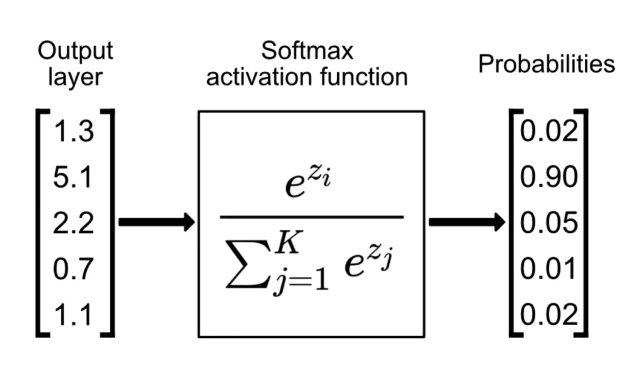

In [33]:
# For example, notice that when we exponentiate, all the negative numbers become > 0 and < 1, and all the positives become > 1
(x_encoded @ W).exp()

tensor([[13.7881,  0.1417,  0.4593,  2.9209,  1.9950,  0.3615,  2.2283,  0.2639,
          2.0314,  1.9305,  1.3567, 10.1391,  1.3952,  3.6488,  0.8115,  0.6932,
          4.1805,  1.2732,  5.8148,  1.5594,  0.4626,  0.2491, 16.3674,  1.7308,
          1.1718,  0.6785,  0.5940],
        [ 0.7724,  0.4910,  8.1878,  0.7254,  3.0696,  0.8217,  0.5658,  0.8250,
          0.2423,  0.9142,  2.2930,  2.8124,  1.5679,  1.1073,  0.8660,  2.0354,
          2.5950,  0.3158,  1.4614,  2.6966,  0.6655,  1.8308,  0.5750,  2.2122,
          0.3590,  0.3020,  4.3788],
        [ 1.4266,  0.0630,  0.8614,  3.6996,  0.3646,  0.2950,  0.6277,  2.5155,
          1.4378,  0.2953,  0.8972,  0.2006,  3.1547,  3.1588,  2.0346, 30.7640,
          0.0851,  0.5922,  1.3748,  0.2878,  1.4203,  0.6341,  0.6740, 11.0957,
          5.7452,  3.6556,  0.2562],
        [ 1.4266,  0.0630,  0.8614,  3.6996,  0.3646,  0.2950,  0.6277,  2.5155,
          1.4378,  0.2953,  0.8972,  0.2006,  3.1547,  3.1588,  2.0346, 30.7640

In [37]:
logits = x_encoded @ W # aka our log-counts

#Apply the softmax
counts = logits.exp() # Our logit exp equivalent to our N matrix (bigrams frequency matrix)
prob = counts / counts.sum(1, keepdims=True) # Our probability distribution where we normalize the rows
prob #Every row will of course sum to 1. This tells us what probability our neural net assigned for each character being the second one given the first one

tensor([[0.1762, 0.0018, 0.0059, 0.0373, 0.0255, 0.0046, 0.0285, 0.0034, 0.0260,
         0.0247, 0.0173, 0.1296, 0.0178, 0.0466, 0.0104, 0.0089, 0.0534, 0.0163,
         0.0743, 0.0199, 0.0059, 0.0032, 0.2092, 0.0221, 0.0150, 0.0087, 0.0076],
        [0.0173, 0.0110, 0.1832, 0.0162, 0.0687, 0.0184, 0.0127, 0.0185, 0.0054,
         0.0205, 0.0513, 0.0629, 0.0351, 0.0248, 0.0194, 0.0455, 0.0581, 0.0071,
         0.0327, 0.0603, 0.0149, 0.0410, 0.0129, 0.0495, 0.0080, 0.0068, 0.0980],
        [0.0184, 0.0008, 0.0111, 0.0477, 0.0047, 0.0038, 0.0081, 0.0324, 0.0185,
         0.0038, 0.0116, 0.0026, 0.0406, 0.0407, 0.0262, 0.3964, 0.0011, 0.0076,
         0.0177, 0.0037, 0.0183, 0.0082, 0.0087, 0.1430, 0.0740, 0.0471, 0.0033],
        [0.0184, 0.0008, 0.0111, 0.0477, 0.0047, 0.0038, 0.0081, 0.0324, 0.0185,
         0.0038, 0.0116, 0.0026, 0.0406, 0.0407, 0.0262, 0.3964, 0.0011, 0.0076,
         0.0177, 0.0037, 0.0183, 0.0082, 0.0087, 0.1430, 0.0740, 0.0471, 0.0033],
        [0.0103, 0.0240,

We will then adjust our weights to continuously improve our probabilities by minimizing the loss

TO SUMMARIZE!

In [44]:
# randomly init 27 neuron weights, with each neuron receiving 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g)

In [45]:
# Essentially our first forward-pass
x_encoded = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = x_encoded @ W #predict log-counts, pass input to our first layer, apply weights

#Apply softmax activation functon to get probabilities
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

Note that everything we have is differentiable, so we can then backpropagate to get our gradients and adjust the parameters (in this case, just the weights). So we can minimize the loss by calculating our gradients and using them to tune our weights.

So our forwardpass gave us the probabilities at the output, and now we can use them to calculate our average negative log likelihood aka our loss, and then use that to backprop

In [51]:
# Let's break it down for our 5 examples (aka .emma.)
nlls = torch.zeros(5)
for i in range(5):
  #i-th bigram
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {reverse_lookup[x]}{reverse_lookup[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label/target character:', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood ( very bad :( ), i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label/target character: 5
probability assigned by the net to the the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label/target character: 13
probability assigned by the net to the the correct character: 0.01805070042610

## What we're gonna do now is very similar to what was done in micrograd, except this is classification rather than regression

In [79]:
# What we're gonna do now is very similar to what was done in micrograd, except this is classification rather than regression

probs[torch.arange(5), ys] # We're interested in probs[0,5] probs[1,13] probs[2,13] probs[3,1] and probs [4, 5]

tensor([0.0123, 0.0181, 0.0267, 0.0737, 0.0150], grad_fn=<IndexBackward0>)

In [80]:
#We want the averange negative log prob
loss = -probs[torch.arange(5), ys].log().mean()
loss #Notive its the exact same as before, but vectorized to calculate it

tensor(3.7693, grad_fn=<NegBackward0>)

In [81]:
# Summarized
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True) # requires_grad to tell pytorch we want the gradient for our leaf tensor

#forward pass
x_encoded = F.one_hot(xs, num_classes=27).float()
logits = x_encoded @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(5), ys].log().mean()

In [ ]:
#backward pass
W.grad = None # set to zero
loss.backward() # We now have the grads of W


In [83]:
W.grad # each number tells us the influence of the weight on our loss (remember from micrograd, positive gradient tells us to decrease the weight, negative tells us to increase)

tensor([[ 0.0121,  0.0020,  0.0025,  0.0008,  0.0034, -0.1975,  0.0005,  0.0046,
          0.0027,  0.0063,  0.0016,  0.0056,  0.0018,  0.0016,  0.0100,  0.0476,
          0.0121,  0.0005,  0.0050,  0.0011,  0.0068,  0.0022,  0.0006,  0.0040,
          0.0024,  0.0307,  0.0292],
        [-0.1970,  0.0017,  0.0079,  0.0020,  0.0121,  0.0062,  0.0217,  0.0026,
          0.0025,  0.0010,  0.0205,  0.0017,  0.0198,  0.0022,  0.0046,  0.0041,
          0.0082,  0.0016,  0.0180,  0.0106,  0.0093,  0.0062,  0.0010,  0.0066,
          0.0131,  0.0101,  0.0018],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

In [86]:
# update based on gradients
W.data += -0.1 * W.grad

# And we would expect our loss to decrease
print("first loss", loss.item())

#forward pass
x_encoded = F.one_hot(xs, num_classes=27).float()
logits = x_encoded @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = -probs[torch.arange(5), ys].log().mean()

print("second loss", loss.item()) # We can now continuously do this to improve our model

first loss 3.7693049907684326
second loss 3.7291417121887207


We now have everything we need to run a neural network

In [113]:
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = lookup_table[ch1]
    ix2 = lookup_table[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

#init the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

number of examples:  228146


In [114]:
# gradient descent
for k in range(100):
  #forward pass
  x_encoded = F.one_hot(xs, num_classes=27).float()
  logits = x_encoded @ W
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  loss = -probs[torch.arange(num), ys].log().mean()
  print(loss.item())

  #backward pass
  W.grad = None #zero_grad
  loss.backward() # Roughly this should get close to 2.47, which is how well we did with our basic bigram counting model

  #update
  W.data += -50 * W.grad #We can afford large steps here

3.758953809738159
3.371100425720215
3.1540427207946777
3.020373582839966
2.927711009979248
2.8604023456573486
2.8097288608551025
2.7701022624969482
2.7380728721618652
2.711496591567993
2.6890032291412354
2.6696884632110596
2.65293025970459
2.638277769088745
2.6253879070281982
2.613990545272827
2.60386323928833
2.5948219299316406
2.5867116451263428
2.5794036388397217
2.572789192199707
2.5667762756347656
2.5612878799438477
2.5562586784362793
2.551633596420288
2.547365665435791
2.543415069580078
2.5397486686706543
2.536336660385132
2.5331544876098633
2.5301804542541504
2.5273969173431396
2.5247862339019775
2.522334337234497
2.520028829574585
2.517857789993286
2.515810966491699
2.513878345489502
2.512052059173584
2.5103237628936768
2.5086872577667236
2.5071349143981934
2.5056614875793457
2.5042612552642822
2.5029289722442627
2.5016608238220215
2.5004520416259766
2.4992988109588623
2.498197317123413
2.4971446990966797
2.4961376190185547
2.495173692703247
2.4942493438720703
2.493363380432129

So we end up with a model that's roughly similar to what we got when doing simply bigram counting. But the advantage is that now we have a much more flexible and fundemanetally simple solution. As we go from this basic neural net all the way to MLPs and Transformers, fundemanetally the principal will remain the same, what will change is how we calculate our logits and how we forward pass.

Currently the way we tokenize by storing combinations in a table is extremely basic and doesn't scale very well to real large language models. The prinicipal, however, will not change, simply the way we represent it.

## Note 1 - W vs N



When we do

logits = xenc @ W

While we say this is like our one-hot inputs being applied to the weights, what's actually happening is that we "pluck out" the i-th position of W (So for example, if position 4 (out of 0!) is the 1, then we're really just fetching the 5th row of weights from the matrix. This is due to how matrix multiplication works (throwback to highschool)

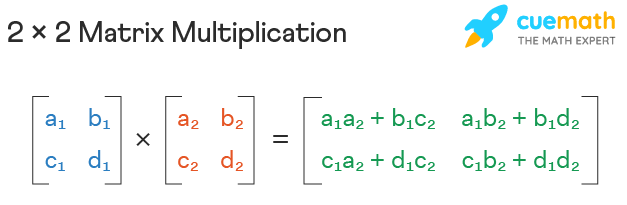

Essentially, our logits are just the row of weights from W we're interested in.

This is why we can say that our W is almost the exact equivalent to the N matrix we had previously, except representing our logits (log-counts) rather than our actual counts

## Note 2 - Smoothing and regularization loss

Recall when we applied smoothing by adding fake counts (N+1). If we were to increase the count by more than just 1, the probabilities would become more and more uniform, aka less and less "spiky".

The gradient based framework, aka the Neural Net here, has a similar mechanism. For example, had we set W to be all zeros, then our exponentiated logits would simply all be 1, meaning that we would have had a completely uniform distribution to begin with. In other words, when our W values are initially all equivalent, then our probabilities come out completely uniform.

So incentivising W to be near zero is a form of smoothing. The greater this incentive, the smoother the model.

This brings us to **regularization loss**.

This allows us to augment our loss function by adding a component known as regularization loss. In our example, we could square the weights to lose our signs. With this number, we achieve 0 regularized loss as the values of W are closer to 0, but as W has non-zero numbers, we accumulate more and more regularized loss. We can then define a specific regularization rate to apply to our additional loss calculation.

In practice, this mean that not only will be try to adjust our probabilities, but also the smoothness of our model by getting our weights as close as possible to zero (with respect ot he regulariztion rate). We can think of as applying pressure to the weights.

Increasing our regularization rate is the same in prinicipal as increasing our fake count addition with the basic bigram counting model. It smooths the model out and keeps it more "honest", but too much and it will make it perform horribly.

In [127]:
# For example (Look at the loss calculation)
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = lookup_table[ch1]
    ix2 = lookup_table[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

#init the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

# gradient descent
for k in range(100):
  #forward pass
  x_encoded = F.one_hot(xs, num_classes=27).float()
  logits = x_encoded @ W
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # NEW! With this we're not just trying to make our probabilities work out, we also want to get our Ws as close as possible to zero, in order to smooth out our model
  print(loss.item())

  #backward pass
  W.grad = None #zero_grad
  loss.backward() # Roughly this should get close to 2.47, which is how well we did with our basic bigram counting model

  #update
  W.data += -50 * W.grad #We can afford large steps here

number of examples:  228146
3.7686190605163574
3.3788065910339355
3.16109037399292
3.0271859169006348
2.9344842433929443
2.867231607437134
2.8166542053222656
2.777146339416504
2.7452542781829834
2.7188303470611572
2.696505546569824
2.6773719787597656
2.6608052253723145
2.6463515758514404
2.633664846420288
2.622471570968628
2.6125476360321045
2.6037068367004395
2.595794916152954
2.5886809825897217
2.5822560787200928
2.5764293670654297
2.5711236000061035
2.5662729740142822
2.5618228912353516
2.5577263832092285
2.5539441108703613
2.550442695617676
2.5471925735473633
2.5441696643829346
2.5413522720336914
2.538722038269043
2.536262035369873
2.5339581966400146
2.531797409057617
2.529768228530884
2.527859926223755
2.5260636806488037
2.5243701934814453
2.522773265838623
2.52126407623291
2.519836902618408
2.5184857845306396
2.5172054767608643
2.515990734100342
2.5148372650146484
2.5137407779693604
2.512697696685791
2.511704921722412
2.5107581615448
2.509854555130005
2.5089924335479736
2.5081682

## Final word for Neural Net: How to sample

In [134]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
  out = []
  ix = 0
  while True:
     #With our bigram model, it was probs = Probabilities[ix]. Now its
     logits = F.one_hot(torch.tensor([ix]), num_classes=27).float() @ W
     counts = logits.exp()
     probs = counts / counts.sum(1, keepdims=True)

     ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
     out.append(reverse_lookup[ix])
     if ix == 0:
      break
  print(''.join(out)) # Hint it still kinda sucks

junide.
janasah.
p.
cfay.
a.
nn.
kohin.
tolian.
juwe.
kalanaauranilevias.
